In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import os
from scipy.stats import skew, kurtosis, normaltest
import re
from collections import Counter
from bidi.algorithm import get_display
import arabic_reshaper


In [4]:
df = pd.read_excel("../data/ER_data.xlsx")

In [6]:
# ========= 4. Minimal columns: ID + EER_text =========
EER_col = "EER_text"
base_cols = ["ID", EER_col]

main_df = df[base_cols].copy()
print("Rows before cleaning:", len(main_df))

# ========= 5. Keep only EER_text =========
main_df["text"] = main_df[EER_col].fillna("").astype(str)

# ========= 6. Remove empty text (less than 5 chars) =========
main_df = main_df[main_df["text"].str.len() > 5].copy()
print("Rows after removing empty text:", len(main_df))

# ========= 7. Keep only columns needed for NLP =========
eer_df = main_df[["ID", "text"]]

print(eer_df.info())
print(eer_df.head())

Rows before cleaning: 659
Rows after removing empty text: 426
<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, 0 to 656
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      426 non-null    object
 1   text    426 non-null    object
dtypes: object(2)
memory usage: 10.0+ KB
None
      ID                                               text
0  30840  אני רוצה להאמין שהחטופים יחזרו אלינו, ולהזכיר ...
1  82080  אפשר להתנחם בכך שהיא נרגעה לאחר מכן ובתום השבע...
2  75872  עשית החלטה נכונה מתוך שיקול הדעת בשביל לחסוך ל...
3  14062  את עושה מה שאת יכולה , את צריכה גם לנשום , מקס...
4  80133  אני בן אדם ולא מכונה . פחד משתק וגורם לצאת משל...


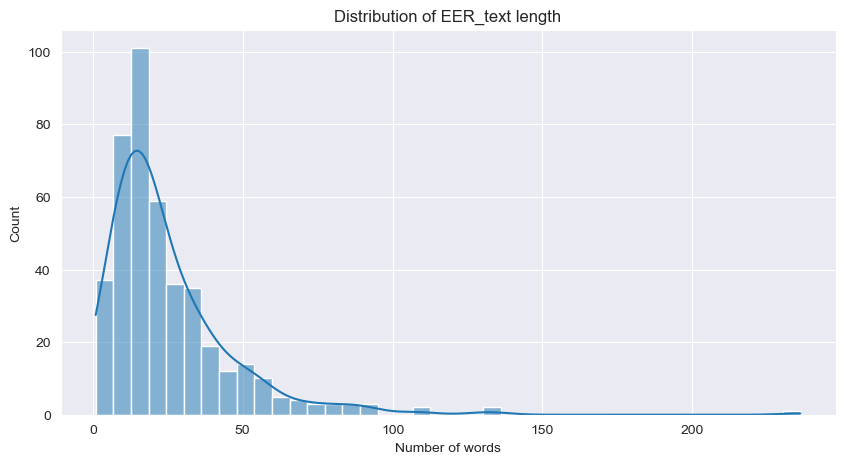

Mean length: 25.248826291079812
Median length: 18.0
Skew: 3.34926454273088
Kurtosis: 20.859346894832324


,ID,text,text_length,clean_text
0,30840,"אני רוצה להאמין שהחטופים יחזרו אלינו, ולהזכיר ...",19,אני רוצה להאמין שהחטופים יחזרו אלינו ולהזכיר ל...
1,82080,אפשר להתנחם בכך שהיא נרגעה לאחר מכן ובתום השבע...,14,אפשר להתנחם בכך שהיא נרגעה לאחר מכן ובתום השבע...
2,75872,עשית החלטה נכונה מתוך שיקול הדעת בשביל לחסוך ל...,12,עשית החלטה נכונה מתוך שיקול הדעת בשביל לחסוך ל...
3,14062,"את עושה מה שאת יכולה , את צריכה גם לנשום , מקס...",15,את עושה מה שאת יכולה את צריכה גם לנשום מקסימום...
4,80133,אני בן אדם ולא מכונה . פחד משתק וגורם לצאת משל...,12,אני בן אדם ולא מכונה פחד משתק וגורם לצאת משליט...


In [20]:
# Add text length
eer_df["text_length"] = eer_df["text"].str.split().str.len()

plt.figure(figsize=(10,5))
sns.histplot(eer_df["text_length"], bins=40, kde=True)
plt.title("Distribution of EER_text length")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

print("Mean length:", eer_df["text_length"].mean())
print("Median length:", eer_df["text_length"].median())
print("Skew:", skew(eer_df["text_length"]))
print("Kurtosis:", kurtosis(eer_df["text_length"]))
eer_df.head()

In [13]:
def clean_text(t):
    t = t.lower()
    t = re.sub(r"[^\w\s]", "", t)  # remove punctuation
    t = re.sub(r"\s+", " ", t).strip()
    return t

eer_df["clean_text"] = eer_df["text"].apply(clean_text)
eer_df.head()

,ID,text,text_length,clean_text
0,30840,"אני רוצה להאמין שהחטופים יחזרו אלינו, ולהזכיר ...",19,אני רוצה להאמין שהחטופים יחזרו אלינו ולהזכיר ל...
1,82080,אפשר להתנחם בכך שהיא נרגעה לאחר מכן ובתום השבע...,14,אפשר להתנחם בכך שהיא נרגעה לאחר מכן ובתום השבע...
2,75872,עשית החלטה נכונה מתוך שיקול הדעת בשביל לחסוך ל...,12,עשית החלטה נכונה מתוך שיקול הדעת בשביל לחסוך ל...
3,14062,"את עושה מה שאת יכולה , את צריכה גם לנשום , מקס...",15,את עושה מה שאת יכולה את צריכה גם לנשום מקסימום...
4,80133,אני בן אדם ולא מכונה . פחד משתק וגורם לצאת משל...,12,אני בן אדם ולא מכונה פחד משתק וגורם לצאת משליט...


In [15]:
all_words = []
for text in eer_df["clean_text"]:
    all_words.extend(text.split())

word_counts = Counter(all_words)
top_words = word_counts.most_common(30)
top_words

[('את', 356),
 ('לא', 208),
 ('זה', 183),
 ('אני', 149),
 ('על', 120),
 ('מה', 98),
 ('גם', 88),
 ('טוב', 85),
 ('יותר', 82),
 ('כל', 81),
 ('עם', 77),
 ('לך', 69),
 ('להיות', 68),
 ('של', 68),
 ('שלי', 65),
 ('בסדר', 63),
 ('הילדים', 62),
 ('שאת', 58),
 ('שלך', 56),
 ('לי', 53),
 ('הכל', 52),
 ('יש', 50),
 ('יכולה', 49),
 ('קשה', 48),
 ('אבל', 45),
 ('הוא', 44),
 ('הכי', 42),
 ('עושה', 41),
 ('המצב', 40),
 ('יהיה', 40)]

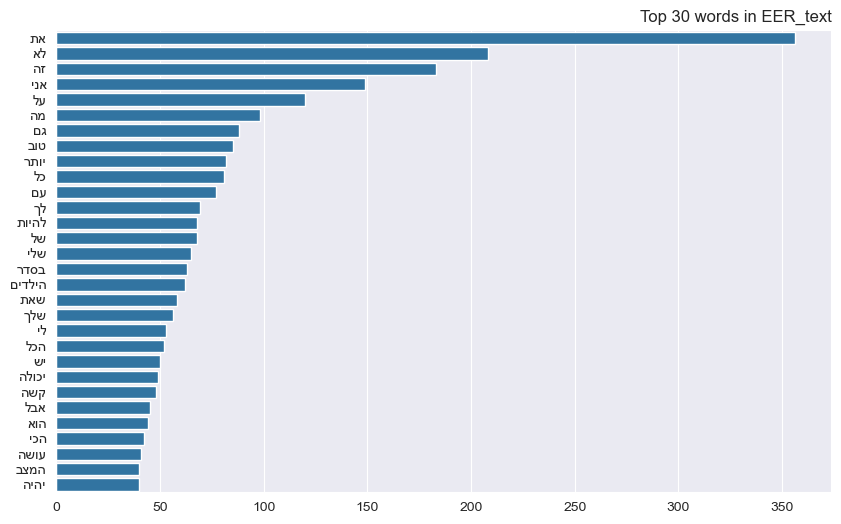

In [19]:
words, counts = zip(*top_words)

# reshape + bidi
reshaped_words = [arabic_reshaper.reshape(w) for w in words]
bidi_words = [get_display(w) for w in reshaped_words]

plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=bidi_words)
plt.title("Top 30 words in EER_text", loc='right')
plt.show()

Series([], Name: count, dtype: int64)
